In [1]:
!pip install yfinance

     |████████████████████████████████| 6.3 MB 3.3 MB/s 
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6


## Stock DATASET

In [2]:
from torch.utils.data import Dataset, DataLoader
from typing import Union
import torch
import yfinance as yf
import pandas as pd
import numpy as np
import os

In [3]:
class StockPriceDataset(Dataset):
    def __init__(self, start_date: str="jj-mm-aaaa", end_date: str="jj-mm-aaaa", 
                 interval: int=1, nb_samples: int=20, transform=None,
                 file_dir: str="data/", csv_file: str=None):

        # If a local data file must be loaded:
        if csv_file is not None:
            self.root_dir = file_dir
            self.filename = csv_file
            with open(os.path.join(file_dir,csv_file), 'r') as file:
                data = pd.read_csv(file, sep=',', header='infer')

        else: # Data must be loaded on an online database:
            dataset = yf.download('^GSPC', start=start_date, end=end_date, interval=interval)

        self.data = dataset
        self.nb_samples = nb_samples
        self.transform = transform

    def __len__(self) -> int:
        return len(self.data)//self.nb_samples

    def __getitem__(self, index) -> Union[torch.Tensor, float]:
        # Load one sample more than nb_samples for normalizing, transform
        sample = self.data['Close'][index*self.nb_samples:(index+1)*self.nb_samples+1]
        # sample = self.data['Close'][index:index+self.nb_samples+1]
        sample = torch.tensor(sample)
        if self.transform:
            sample = self.transform(sample)[1:]
        else:
            sample = sample[1:]
        
        label = sample[-1] # label is the last elem of sample

        sample = sample[:-1] # removes label from sample
        return sample, label

def normalize_by_last_unknown_price(sample: torch.Tensor) -> torch.Tensor:
    """Divides the whole stock price sample by the last unknown price w_{p*t-1}"""
    last_price = sample[0] # w_{pt-1}
    return sample/last_price

[*********************100%***********************]  1 of 1 completed
head of the dataset = Date
1950-01-03    16.66
1950-01-04    16.85
1950-01-05    16.93
1950-01-06    16.98
1950-01-09    17.08
Name: Close, dtype: float64

 Plot of the 'Close' data :


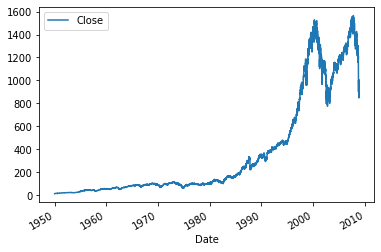

In [20]:
VISUALIZE_DATASET = True
if VISUALIZE_DATASET:
  dataset = StockPriceDataset(start_date='1950-01-03', 
                              end_date='2008-11-16',
                              interval='1d', 
                              nb_samples=15,
                              transform=normalize_by_last_unknown_price)

  print("head of the dataset =", dataset.data.head()['Close'])

  print("\n Plot of the 'Close' data :")
  date = dataset.data.plot(None, ['Close'])

## Modèle

In [4]:
from torch.nn import LSTM, Module, Dropout, ModuleList

In [5]:
class StockAI(Module):
     
    def __init__(self, input_size, lstm_size, num_layers, keep_prob) -> None:
        super().__init__()
        self.input_size = input_size
        self.lstm_size = lstm_size
        self.num_layers = num_layers
        self.lstm = LSTM(self.input_size, hidden_size=1, num_layers=self.num_layers,dropout=1-keep_prob, batch_first=True)
    
    def forward(self,x):
        a, b = self.lstm(x)
        return b[0]
    

## Configuration

In [6]:
class StockAIConfig():
    config = {
        "model":{
            "input_size": 1,
            "lstm_size": 128,
            "num_layers": 1,
            "keep_prob": 0.8
        },

        "dataset_train":{
            "start_date": '1950-01-03',
            "end_date": '2008-11-16',
            "interval_date": '1d',
            "nb_samples":15,
            "batch_size": 16,
            "shuffle":False
        },
        "dataset_test":{
            "start_date": '2008-11-17',
            "end_date": '2021-11-16',
            "interval_date": '1d',
            "nb_samples":15,
            "batch_size": 16,
            "shuffle":False
        },

        "learning":{
            "num_steps": 30,
            "init_lr": 1e-03,
            "lr_decay": 0.99,
            "init_epoch": 5,
            "max_epoch": 50
        }   
    }

##Prediction : Train / Test

In [7]:
import math
import torch
from torch.utils.data import DataLoader
from torch.nn import MSELoss
from torch.optim import RMSprop

In [8]:
# Model config
config = StockAIConfig().config

# CUDA for PyTorch
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
torch.backends.cudnn.benchmark = True

# Init of the Dataset_train
dataset_train = StockPriceDataset(config["dataset_train"]["start_date"], 
                            config["dataset_train"]["end_date"],
                            config["dataset_train"]["interval_date"], 
                            config["dataset_train"]["nb_samples"],
                            transform=normalize_by_last_unknown_price)

# Init dataloader of the Dataset_train
dataloader_train = DataLoader(dataset_train, config["dataset_train"]["batch_size"], config["dataset_train"]["shuffle"], drop_last=True)

# Init of the Dataset_test
dataset_test = StockPriceDataset(config["dataset_test"]["start_date"], 
                            config["dataset_test"]["end_date"],
                            config["dataset_test"]["interval_date"], 
                            config["dataset_test"]["nb_samples"],
                            transform=normalize_by_last_unknown_price)

# Init dataloader of Dataset_test
dataloader_test = DataLoader(dataset_test, config["dataset_test"]["batch_size"], config["dataset_test"]["shuffle"], drop_last=True)

# Init of the model
model = StockAI(config["model"]["input_size"],
                config["model"]["lstm_size"],
                config["model"]["num_layers"],
                config["model"]["keep_prob"])

model.to(device)

# Learning rate to use along the epochs
learning_rates = [config["learning"]["init_lr"] * (config["learning"]["lr_decay"] ** max(float(i + 1 - config["learning"]["init_epoch"]), 0.0)) for i in range(config["learning"]["max_epoch"])]

# Loss
loss_fn = MSELoss()
optimizer = RMSprop(model.parameters(), lr=learning_rates[0], eps=1e-08)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.19999999999999996 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


In [9]:
len(dataloader_train)

61

In [10]:
# Learning
for epoch_step in range(config["learning"]["max_epoch"]):
    lr = learning_rates[epoch_step]
    print(f"Running for epoch {epoch_step}...")
    for i_batch, batch in enumerate(dataloader_train):
        x, y = batch
        x = torch.unsqueeze(x, -1).float()
        y = y.float()
        x, y = x.to(device), y.to(device)
        y_pred = model.forward(x)
        loss = loss_fn(y_pred, y)

        if i_batch%10==0:
            print(f"step: {i_batch}, loss = {loss}")

        # Zero gradients, perform a backward pass, and update the weights.
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

Running for epoch 0...
step: 0, loss = 0.9263932108879089


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([16])) that is different to the input size (torch.Size([1, 16, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


step: 10, loss = 0.8407235741615295
step: 20, loss = 0.7973533868789673
step: 30, loss = 0.774640679359436
step: 40, loss = 0.7388665676116943
step: 50, loss = 0.7148832082748413
step: 60, loss = 0.6506136655807495
Running for epoch 1...
step: 0, loss = 0.6711170673370361
step: 10, loss = 0.6108390688896179
step: 20, loss = 0.5706744194030762
step: 30, loss = 0.5450021028518677
step: 40, loss = 0.5078538656234741
step: 50, loss = 0.4810989797115326
step: 60, loss = 0.42355218529701233
Running for epoch 2...
step: 0, loss = 0.439033567905426
step: 10, loss = 0.3871299624443054
step: 20, loss = 0.3540458679199219
step: 30, loss = 0.33456283807754517
step: 40, loss = 0.3086320757865906
step: 50, loss = 0.29314523935317993
step: 60, loss = 0.2550305128097534
Running for epoch 3...
step: 0, loss = 0.26766008138656616
step: 10, loss = 0.2347518354654312
step: 20, loss = 0.2171539068222046
step: 30, loss = 0.2095564901828766
step: 40, loss = 0.19654951989650726
step: 50, loss = 0.191347107291

In [11]:
#test
runnning_mape = 0
for i_batch, batch in enumerate(dataloader_test):
        x, y = batch
        x = torch.unsqueeze(x, -1).float()
        y = y.float()
        x, y = x.to(device), y.to(device)
        y_pred = model.forward(x)
        error = torch.mean(torch.abs((y - y_pred) / y))
        runnning_mape += error

mape = runnning_mape / len(dataloader_test)
print("",mape)

 tensor(0.0294, device='cuda:0', grad_fn=<DivBackward0>)
